In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
import numpy as np
import matplotlib.pyplot as plt
import time
from sklearn.linear_model import LassoLarsIC
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

In [2]:
df = pd.read_csv("mpg_cleaned.csv")
df.head()

,origin,name,cylinders,model_year,mpg,displacement,horsepower,weight,acceleration
0,usa,chevrolet chevelle malibu,8,70,18.0,307.0,130.0,3504,12.0
1,usa,buick skylark 320,8,70,15.0,350.0,165.0,3693,11.5
2,usa,plymouth satellite,8,70,18.0,318.0,150.0,3436,11.0
3,usa,amc rebel sst,8,70,16.0,304.0,150.0,3433,12.0
4,usa,ford torino,8,70,17.0,302.0,140.0,3449,10.5


In [3]:
print(df['origin'].value_counts())
print(df['cylinders'].value_counts())
print(df['model_year'].value_counts())

usa       245
japan      79
europe     68
Name: origin, dtype: int64
4    199
8    103
6     83
3      4
5      3
Name: cylinders, dtype: int64
73    40
78    36
76    34
75    30
82    30
70    29
79    29
72    28
77    28
81    28
71    27
80    27
74    26
Name: model_year, dtype: int64


In [4]:
##Here model year is categorical variable
df['model_year'] = pd.Categorical(df['model_year'])
df['model_year'].dtype

CategoricalDtype(categories=[70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82], ordered=False)

In [5]:
y = df['mpg']
x = df.drop(['mpg', 'name','origin'], axis = 1)

In [6]:
##Standardizing the dataset
scaler = StandardScaler().fit(x) 
x = scaler.transform(x)

Splitting test train in the ratio of 2:8

In [7]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=10)
reg = Lasso(alpha=1)
model = reg.fit(x_train, y_train)

In [8]:
print('In sample R squared', round(reg.score(x_train, y_train)*100, 2))
print('Out of sample R squared', round(reg.score(x_test, y_test)*100, 2))

In sample R squared 78.54
Out of sample R squared 76.72


In [9]:
#MSE for the training and test set.

# Training data
pred_train = reg.predict(x_train)
mse_train = mean_squared_error(y_train, pred_train)
print('MSE training set', round(mse_train, 2))

# Test data
pred = reg.predict(x_test)
mse_test =mean_squared_error(y_test, pred)
print('MSE test set', round(mse_test, 2))

MSE training set 12.89
MSE test set 14.29


In [10]:
def AIC_BIC_AICc(n,k,residuals):
    ll = -(n * 1/2) * (1 + np.log(2 * np.pi)) - (n / 2) * np.log(residuals.dot(residuals) / n)
    AIC = (-2 * ll) + (2 * k)
    BIC = (-2 * ll) + (k * np.log(n))
    AICc = AIC + (2*k*(k+1)/(n-k-1))
    return AIC, BIC,AICc

In [11]:
residual = y_train - pred_train
print('AIC, BIC and AICc are', AIC_BIC_AICc(x_train.shape[0], x_train.shape[1], residual))

AIC, BIC and AICc are (1700.3986620293517, 1722.8758811725927, 1700.6731718332733)


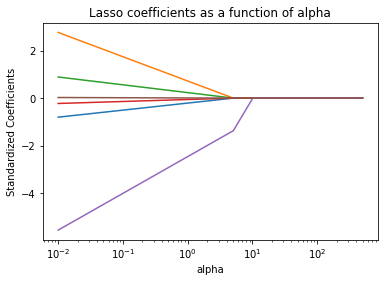

In [12]:
alphas = np.linspace(0.01,500,100)
lasso = Lasso(max_iter=10000)
coefs = []

for a in alphas:
    lasso.set_params(alpha=a)
    lasso.fit(x_train, y_train)
    coefs.append(lasso.coef_)

ax = plt.gca()

ax.plot(alphas, coefs)
ax.set_xscale('log')
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('Standardized Coefficients')
plt.title('Lasso coefficients as a function of alpha');

To find the optimal value of alpha, we use scikit learns lasso linear model with iterative fitting along a regularization path (LassoCV).  
We will first fit a Lasso model with the AIC criterion.  

In [13]:
start_time = time.time()
lasso_lars_ic = make_pipeline(
    StandardScaler(), LassoLarsIC(criterion="aic", normalize=False)
).fit(x, y)
fit_time = time.time() - start_time

We store the AIC metric for each value of alpha used during fit.

In [14]:
results = pd.DataFrame(
    {
        "alphas": lasso_lars_ic[-1].alphas_,
        "AIC criterion": lasso_lars_ic[-1].criterion_,
    }
).set_index("alphas")
alpha_aic = lasso_lars_ic[-1].alpha_

Now, we perform the same analysis using the BIC criterion.

In [15]:
lasso_lars_ic.set_params(lassolarsic__criterion="bic").fit(x, y)
results["BIC criterion"] = lasso_lars_ic[-1].criterion_
alpha_bic = lasso_lars_ic[-1].alpha_

We can check which value of alpha leads to the minimum AIC and BIC.

In [16]:
def highlight_min(x):
    x_min = x.min()
    return ["font-weight: bold" if v == x_min else "" for v in x]


results.style.apply(highlight_min)

,AIC criterion,BIC criterion
alphas,,
6.487381740339966,3706.377358,3706.377358
3.6474703170531315,2752.299865,2756.271127
2.032748934242374,2288.837941,2296.780465
0.847226886967307,2117.338143,2129.251928
0.1859129727607712,2084.356344,2100.241391
0.08690555633923544,2082.563217,2098.448265
0.02081139989824289,2082.138769,2098.023817
0.002867437793699691,2082.995689,2102.851998
0.0,2084.972769,2108.800340


In [17]:
n = x_train.shape[0]
k = x_train.shape[1]

print('AIC for Question 2 is:',min(results['AIC criterion']))
print('BIC for Question 2 is:', min(results['BIC criterion']))
print('AICc for Question 2 is:', (min(results['AIC criterion'] + (2*k*(k+1)/(n-k-1)))))

AIC for Question 2 is: 2082.1387694606588
BIC for Question 2 is: 2098.0238168198207
AICc for Question 2 is: 2082.4132792645805


In [18]:
alpa_best = alpha_aic

Model selection with an information-criterion is very fast. It relies on computing the criterion on the in-sample set provided to fit. Both criteria estimate the model generalization error based on the training set error and penalize this overly optimistic error. However, this penalty relies on a proper estimation of the degrees of freedom and the noise variance. Both are derived for large samples (asymptotic results) and assume the model is correct, i.e. that the data are actually generated by this model.

These models also tend to break when the problem is badly conditioned (more features than samples). It is then required to provide an estimate of the noise variance.

In [19]:
# Set best alpha
lasso_best = Lasso(alpha=alpa_best)
lasso_best.fit(x_train, y_train)

Lasso(alpha=0.02081139989824289)

In [20]:
print(list(zip(lasso_best.coef_, x)))

[(-0.5898381711351537, array([ 1.48394702, -1.62531533,  1.07728956,  0.66413273,  0.62054034,
       -1.285258  ])), (2.748432970140262, array([ 1.48394702, -1.62531533,  1.48873169,  1.57459447,  0.84333403,
       -1.46672362])), (0.4438194968243105, array([ 1.48394702, -1.62531533,  1.1825422 ,  1.18439658,  0.54038176,
       -1.64818924])), (-0.14081181781954705, array([ 1.48394702, -1.62531533,  1.04858429,  1.18439658,  0.53684535,
       -1.285258  ])), (-5.406419848578306, array([ 1.48394702, -1.62531533,  1.02944745,  0.92426466,  0.5557062 ,
       -1.82965485])), (0.004659644798272906, array([ 1.48394702, -1.62531533,  2.244637  ,  2.43302983,  1.60719812,
       -2.01112047]))]


In [21]:
print('R squared training set', round(lasso_best.score(x_train, y_train)*100, 2))   ###We are using model with 0.2 test size
print('R squared test set', round(lasso_best.score(x_test, y_test)*100, 2))

R squared training set 81.23
R squared test set 78.79


In [22]:
#MSE for the training and test set.

# Training data
pred_train = lasso_best.predict(x_train)
mse_train = mean_squared_error(y_train, pred_train)
print('MSE training set', round(mse_train, 2))

# Test data
pred = lasso_best.predict(x_test)
mse_test =mean_squared_error(y_test, pred)
print('MSE test set', round(mse_test, 2))

MSE training set 11.27
MSE test set 13.01


k-fold cross validation To find the optimal value of alpha, we use scikit learns lasso linear model with iterative fitting along a regularization path (LassoCV). The best model is selected by cross-validation.

In [23]:
# 10 fold cross-validation
model_kfold = KFold(n_splits=10, random_state=1, shuffle=True)
model_lin = LinearRegression()

#Creating the model using the complete dataset we have and scoring the R square values
model_cv = cross_val_score(model_lin, x, y, scoring='r2', cv=model_kfold, n_jobs=-1)

print(model_cv)

[0.80850252 0.81854472 0.81194323 0.80668736 0.74555587 0.76779445
 0.83387077 0.75471997 0.80292936 0.85344546]


In [24]:
print(np.mean(model_cv))

0.8003993706372263


R squared of is much more improved than above models for each bucket, as we use 10 folds for cross validations. Though the amount of time increases for increaing the folds the model accuracy increases. 